In [1]:
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.documents import Document

import os

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"),model="gpt-3.5-turbo")
embeddings = OpenAIEmbeddings(api_key=os.getenv("OPENAI_API_KEY"), model="text-embedding-3-large")

loader = PyPDFLoader("data/attention.pdf")
docs = loader.load()
print(docs)

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = splitter.split_documents(docs)

#vector_store = FAISS.add_documents(documents=all_splits)
vector_store = FAISS.from_documents(all_splits,embedding=embeddings)



[Document(metadata={'source': 'data/attention.pdf', 'page': 0, 'page_label': '1'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple networ

### Using predefine prompts from langchain hub. Refer teh screenshot below

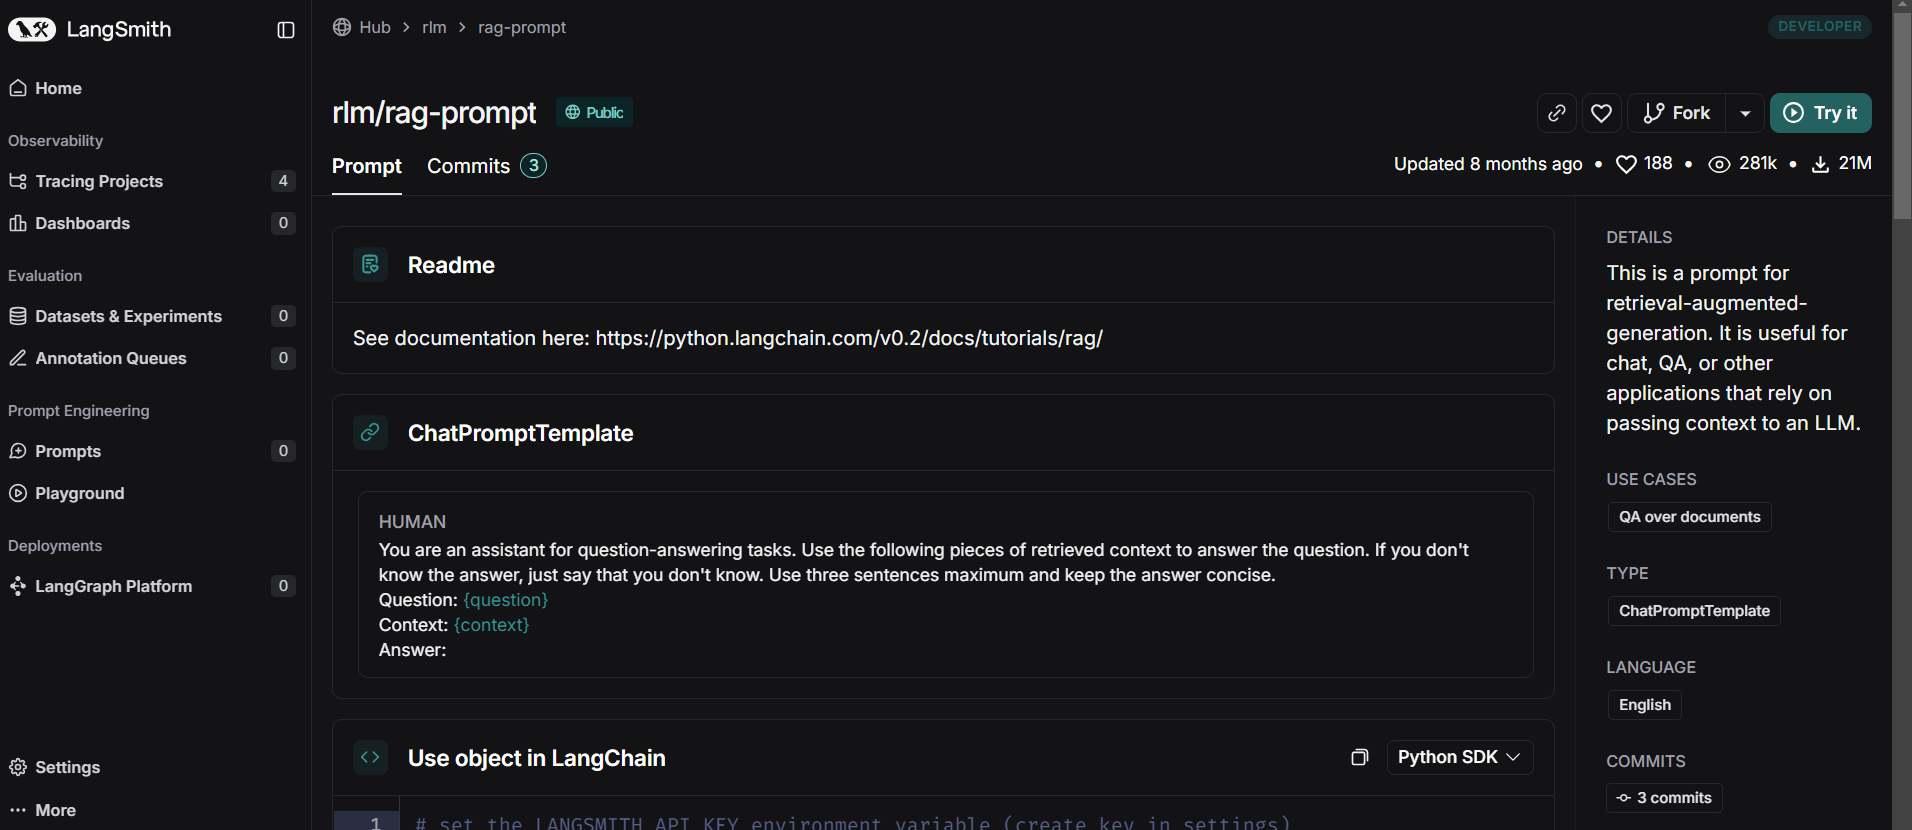

In [4]:
# pull the prompt for RAG from langchain hub
prompt = hub.pull("rlm/rag-prompt")

In [5]:
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### Build the Langgraph which works on a state, dictionary in this case

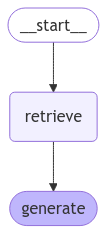

In [7]:
from IPython.display import display, Image

class MyState(TypedDict):
    question: str
    context: list[Document]
    answer: str

def retrieve(state: MyState):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: MyState):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}



# Compile application and test
graph_builder = StateGraph(MyState).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
result = graph.invoke({"question":"Who authored the paper for attention?"})
result

{'question': 'Who authored the paper for attention?',
 'context': [Document(id='18a35e9b-041d-41e4-a9a8-19890954b181', metadata={'source': 'data/attention.pdf', 'page': 0, 'page_label': '1'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperformin

In [10]:
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='18a35e9b-041d-41e4-a9a8-19890954b181', metadata={'source': 'data/attention.pdf', 'page': 0, 'page_label': '1'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an 

[Document(id='18a35e9b-041d-41e4-a9a8-19890954b181', metadata={'source': 'data/attention.pdf', 'page': 0, 'page_label': '1'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention